In [1]:
import gc
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import statsmodels.api as sm

from calendar import monthrange
from googletrans import Translator

from itertools import product 

from xgboost import XGBRegressor
from xgboost import plot_importance

%matplotlib inline

pd.set_option('display.max_colwidth', 500)
pd.set_option('display.max_rows', 500)

In [2]:
data_df = pd.read_csv('./data/sales_train.csv')
print('Data rows:  {:,}'.format(len(data_df)))

data_df['date'] = pd.to_datetime(data_df['date'], format='%d.%m.%Y')

# Let's break up the date field into constituent pieces.
data_df['date (year)'] = data_df['date'].dt.year
data_df['date (month)'] = data_df['date'].dt.month
data_df['date (days in month)'] = data_df['date'].apply(lambda x: monthrange(x.year, x.month)[1])

data_df.head(2).transpose()

Data rows:  2,935,849


,0,1
date,2013-01-02 00:00:00,2013-01-03 00:00:00
date_block_num,0,0
shop_id,59,25
item_id,22154,2552
item_price,999,899
item_cnt_day,1,1
date (year),2013,2013
date (month),1,1
date (days in month),31,31


In [3]:
data_df = data_df[
    (data_df['item_price'] >= 0) &
    (data_df['item_price'] < 100000)
]
print('Data rows:  {:,}'.format(len(data_df)))

Data rows:  2,935,847


In [4]:
test_df = pd.read_csv('./data/test.csv')
print('Test rows:  {:,}'.format(len(test_df)))

# Fixed values.
test_df['date_block_num'] = 34
test_df['date (year)'] = 2015
test_df['date (month)'] = 11
test_df['date (days in month)'] = 30

# Update the prices with the latest month's prices.
last_month_df = data_df[data_df['date_block_num'] == 33][['shop_id', 'item_id', 'item_price']]

test_df = test_df.merge(last_month_df, on=['shop_id', 'item_id'], how='left')

test_df = test_df.drop_duplicates('ID', keep='first')

print('Test rows (after merge):  {:,}'.format(len(test_df)))

test_df[test_df['item_price'] > 0].head(2).T

Test rows:  214,200
Test rows (after merge):  214,200


,2,5
ID,2.0,5.0
shop_id,5.0,5.0
item_id,5233.0,5039.0
date_block_num,34.0,34.0
date (year),2015.0,2015.0
date (month),11.0,11.0
date (days in month),30.0,30.0
item_price,1199.0,1499.0


Are there shop/items pairs in the test set that don't exist in the training set?  Yes, so let's load a pre-crafted dataset of shop/item pairs with default data.

In [5]:
missing_df = pd.read_csv('./data/train_missing2.csv')
print('Missing shop/item pairs:  {:,}'.format(len(missing_df)))

missing_df.head(5)

Missing shop/item pairs:  205,592


,date_block_num,date,date (year),date (month),date (days in month),shop_id,item_id,item_price,item_cnt_day
0,32,2015-09-01,2015,9,30,5,5320,0,0
1,33,2015-10-01,2015,10,31,5,5320,0,0
2,32,2015-09-01,2015,9,30,5,5268,0,0
3,33,2015-10-01,2015,10,31,5,5268,0,0
4,32,2015-09-01,2015,9,30,5,5003,0,0


In [6]:
data_df = pd.concat([data_df, missing_df, test_df], ignore_index=True, sort=False)

print('Rows:  {:,}'.format(len(data_df)))

Rows:  3,355,639


In [7]:
data_df.loc[data_df.shop_id == 0, 'shop_id'] = 57
# Якутск ТЦ "Центральный"
data_df.loc[data_df.shop_id == 1, 'shop_id'] = 58
# Жуковский ул. Чкалова 39м²
data_df.loc[data_df.shop_id == 11, 'shop_id'] = 10
# РостовНаДону ТРК "Мегацентр Горизонт" Островной
data_df.loc[data_df.shop_id == 40, 'shop_id'] = 39

In [8]:
items_df = pd.read_csv('./data/items.csv')
print('Items:  {:,}'.format(len(items_df)))

items_df['item_id'] = items_df['item_id'].astype(int)
items_df['item_category_id'] = items_df['item_category_id'].astype(int)

items_df.head(3)

Items:  22,170


,item_name,item_id,item_category_id
0,! ВО ВЛАСТИ НАВАЖДЕНИЯ (ПЛАСТ.) D,0,40
1,"!ABBYY FineReader 12 Professional Edition Full [PC, Цифровая версия]",1,76
2,***В ЛУЧАХ СЛАВЫ (UNV) D,2,40


In [9]:
item_categories_df = pd.read_csv('./data/item_categories.csv')
print('Item Categories:  {:,}'.format(len(item_categories_df)))

item_categories_df['item_category_id'] = item_categories_df['item_category_id'].astype(int)

translator = Translator()

#item_categories_df['item_category_name (english)'] = item_categories_df['item_category_name'].apply(lambda x: translator.translate(x).text)

# Following english categories were taken from the output file written above.
def get_english_category(x):
    if 0 <= x <= 7:
        return 'Accessories'
    elif 10 <= x <= 17:
        return 'Game Consoles'
    elif 18 <= x <= 31:
        return 'Games'
    elif 32 <= x <= 36:
        return 'Gift Cards'
    elif 37 <= x <= 41:
        return 'Movies'
    elif 42 <= x <= 54:
        return 'Books'
    elif 55 <= x <= 60:
        return 'Music'
    elif 61 <= x <= 72:
        return 'Gifts'
    elif 73 <= x <= 79:
        return 'Software'
    else:
        return 'Misc'
    
item_categories_df['cat_name (normalized)'] = item_categories_df['item_category_id'].apply(lambda x: get_english_category(x))
item_categories_df['cat_name (normalized)'] = item_categories_df['cat_name (normalized)'].astype('category')
item_categories_df['cat_name (code)'] = item_categories_df['cat_name (normalized)'].cat.codes

item_categories_df['category_type'] = item_categories_df['item_category_name'].str.split('-').apply(lambda x: x[0].strip())
item_categories_df['category_type'] = item_categories_df['category_type'].astype('category')
item_categories_df['category_type'] = item_categories_df['category_type'].cat.codes

item_categories_df['category_subtype'] = item_categories_df['item_category_name'].str.split('-').apply(lambda x: x[1].strip() if len(x) > 1 else x[0].strip())
item_categories_df['category_subtype'] = item_categories_df['category_subtype'].astype('category')
item_categories_df['category_subtype'] = item_categories_df['category_subtype'].cat.codes

item_categories_df.head(3)

Item Categories:  84


,item_category_name,item_category_id,cat_name (normalized),cat_name (code),category_type,category_subtype
0,PC - Гарнитуры/Наушники,0,Accessories,0,0,29
1,Аксессуары - PS2,1,Accessories,0,1,9
2,Аксессуары - PS3,2,Accessories,0,1,10


In [10]:
shops_df = pd.read_csv('./data/shops.csv')
print('Shop rows:  {:,}'.format(len(shops_df)))

shops_df['shop_id'] = shops_df['shop_id'].astype(int)
#shops_df['shop_name (english)'] = shops_df['shop_name'].apply(lambda x: translator.translate(x).text)

shops_df['shop_loc'] = shops_df['shop_name'].apply(lambda x: str(x).split(' ')[0]).astype('category')
shops_df['shop_loc (code)'] = shops_df['shop_loc'].cat.codes

shops_df.head(3)

Shop rows:  60


,shop_name,shop_id,shop_loc,shop_loc (code)
0,"!Якутск Орджоникидзе, 56 фран",0,!Якутск,0
1,"!Якутск ТЦ ""Центральный"" фран",1,!Якутск,0
2,"Адыгея ТЦ ""Мега""",2,Адыгея,1


In [11]:
monthly_df = data_df.groupby(['shop_id', 'item_id', 'date_block_num']).agg({'item_cnt_day': 'sum'}).reset_index()
monthly_df.columns = ['shop_id', 'item_id', 'date_block_num', 'item_cnt_month']

In [12]:
print('Training before merge:  {:,}'.format(len(data_df)))

data_df = data_df.merge(monthly_df, on=['shop_id', 'item_id', 'date_block_num'], how='left')
data_df = data_df.fillna(0)

data_df = data_df.merge(items_df[['item_id', 'item_category_id']], on='item_id', how='left')
data_df = data_df.merge(item_categories_df[['item_category_id', 'cat_name (code)', 'category_type', 'category_subtype']], 
                        on='item_category_id', 
                        how='left')
data_df = data_df.merge(shops_df[['shop_id', 'shop_loc (code)']], on='shop_id', how='left')

data_df['date_block_num'] = data_df['date_block_num'].astype('int')
data_df['shop_id'] = data_df['shop_id'].astype('int')
data_df['item_id'] = data_df['item_id'].astype('int')
data_df['item_category_id'] = data_df['item_category_id'].astype('int')
data_df['date (year)'] = data_df['date (year)'].astype('int')
data_df['date (month)'] = data_df['date (month)'].astype('int')
data_df['date (days in month)'] = data_df['date (days in month)'].astype('int')

data_df['item_cnt_month'] = data_df['item_cnt_month'].clip(0 ,20)

print('Training after merge:  {:,}'.format(len(data_df)))

# Drop the daily columns that aren't needed.
data_df = data_df.drop(['date', 'item_cnt_day'], axis=1)

data_df.head(2).T

Training before merge:  3,355,639
Training after merge:  3,355,639


,0,1
date_block_num,0.0,0.0
shop_id,59.0,25.0
item_id,22154.0,2552.0
item_price,999.0,899.0
date (year),2013.0,2013.0
date (month),1.0,1.0
date (days in month),31.0,31.0
ID,0.0,0.0
item_cnt_month,1.0,0.0
item_category_id,37.0,58.0


In [13]:
float_cols = [col for col in data_df if data_df[col].dtype == 'float64']
int_cols = [col for col in data_df if data_df[col].dtype in ['int64', 'int32']]

data_df[float_cols] = data_df[float_cols].astype(np.float32)
data_df[int_cols] = data_df[int_cols].astype(np.int16)

In [14]:
#data_df = data_df[
#    (data_df['shop_id'].isin(test_df['shop_id'].unique())) &
#    (data_df['item_id'].isin(test_df['item_id'].unique()))
#]
#print('Training after removing shops/items not in the test set:  {:,}'.format(len(data_df)))

In [15]:
data_df = data_df[
    (data_df['item_cnt_month'] >= 0) &
    (data_df['item_cnt_month'] < 1000)
]
print('Training after clipping (0, 1000) on the target variable:  {:,}'.format(len(data_df)))

Training after clipping (0, 1000) on the target variable:  3,355,639


In [16]:
data_df['date (holiday season)'] = data_df['date (month)'].apply(lambda x: 1 if x == 12 else 0)

In [17]:
data_df['item_price (unit)'] = data_df['item_price'] // data_df['item_cnt_month']

In [18]:
data_df['shop (first sale)'] = data_df['date_block_num'] - data_df.groupby(['item_id', 'shop_id'])['date_block_num'].transform('min')

In [19]:
# Item count by date_block_num
grouped_df = data_df.groupby(['date_block_num']).agg({'item_cnt_month': ['mean']}).reset_index()
grouped_df.columns = ['date_block_num', 'item_cnt_mef (date_block_num)']

print(grouped_df.head(3))
print('')

data_df = pd.merge(data_df, grouped_df, on=['date_block_num'], how='left')
print('Rows after merge:  {:,}'.format(len(data_df)))

# Item count by month
grouped_df = data_df.groupby(['date (month)']).agg({'item_cnt_month': ['mean']}).reset_index()
grouped_df.columns = ['date (month)', 'item_cnt_mef (month)']

print(grouped_df.head(3))
print('')

data_df = pd.merge(data_df, grouped_df, on=['date (month)'], how='left')
print('Rows after merge:  {:,}'.format(len(data_df)))
print('')

# Item count by year
grouped_df = data_df.groupby(['date (year)']).agg({'item_cnt_month': ['mean']}).reset_index()
grouped_df.columns = ['date (year)', 'item_cnt_mef (year)']

print(grouped_df.head(3))
print('')

data_df = pd.merge(data_df, grouped_df, on=['date (year)'], how='left')
print('Rows after merge:  {:,}'.format(len(data_df)))
print('')

# Item count by item_category, date_block_num
grouped_df = data_df.groupby(['date_block_num', 'item_category_id']).agg({'item_cnt_month': ['mean']}).reset_index()
grouped_df.columns = ['date_block_num', 'item_category_id', 'item_cat_cnt_mef (date_block_num)']

print(grouped_df.head(3))
print('')

data_df = pd.merge(data_df, grouped_df, on=['date_block_num', 'item_category_id'], how='left')
print('Rows after merge:  {:,}'.format(len(data_df)))

# Item count by item_category, month
grouped_df = data_df.groupby(['date (month)', 'item_category_id']).agg({'item_cnt_month': ['mean']}).reset_index()
grouped_df.columns = ['date (month)', 'item_category_id', 'item_cat_cnt_mef (month)']

print(grouped_df.head(3))
print('')

data_df = pd.merge(data_df, grouped_df, on=['date (month)', 'item_category_id'], how='left')
print('Rows after merge:  {:,}'.format(len(data_df)))

# Item count by cat (code), month
grouped_df = data_df.groupby(['date (month)', 'cat_name (code)']).agg({'item_cnt_month': ['mean']}).reset_index()
grouped_df.columns = ['date (month)', 'cat_name (code)', 'cat_name_cnt_mef (month)']

print(grouped_df.head(3))
print('')

data_df = pd.merge(data_df, grouped_df, on=['date (month)', 'cat_name (code)'], how='left')
print('Rows after merge:  {:,}'.format(len(data_df)))

# Item count by cat (code), shop, month
grouped_df = data_df.groupby(['date (month)', 'shop_id', 'cat_name (code)']).agg({'item_cnt_month': ['mean']}).reset_index()
grouped_df.columns = ['date (month)', 'cat_name (code)', 'shop_id', 'cat_name_shop_cnt_mef (month)']

print(grouped_df.head(3))
print('')

data_df = pd.merge(data_df, grouped_df, on=['date (month)', 'shop_id', 'cat_name (code)'], how='left')
print('Rows after merge:  {:,}'.format(len(data_df)))

# Item count by cat (code), shop, date_block_num
grouped_df = data_df.groupby(['date_block_num', 'shop_id', 'cat_name (code)']).agg({'item_cnt_month': ['mean']}).reset_index()
grouped_df.columns = ['date_block_num', 'cat_name (code)', 'shop_id', 'cat_name_shop_cnt_mef (date_block_num)']

print(grouped_df.head(3))
print('')

data_df = pd.merge(data_df, grouped_df, on=['date_block_num', 'shop_id', 'cat_name (code)'], how='left')
print('Rows after merge:  {:,}'.format(len(data_df)))

# Item count by shop_loc, date_block_num
grouped_df = data_df.groupby(['date_block_num', 'shop_loc (code)']).agg({'item_cnt_month': ['mean']}).reset_index()
grouped_df.columns = ['date_block_num', 'shop_loc (code)', 'shop_loc_cnt_mef (date_block_num)']

print(grouped_df.head(3))
print('')

data_df = pd.merge(data_df, grouped_df, on=['date_block_num', 'shop_loc (code)'], how='left')
print('Rows after merge:  {:,}'.format(len(data_df)))

# Item count by shop_loc, item, date_block_num
grouped_df = data_df.groupby(['date_block_num', 'shop_loc (code)', 'item_id']).agg({'item_cnt_month': ['mean']}).reset_index()
grouped_df.columns = ['date_block_num', 'shop_loc (code)', 'item_id', 'shop_loc_item_cnt_mef (date_block_num)']

print(grouped_df.head(3))
print('')

data_df = pd.merge(data_df, grouped_df, on=['date_block_num', 'shop_loc (code)', 'item_id'], how='left')
print('Rows after merge:  {:,}'.format(len(data_df)))

# Item count by shop_loc, cat (code), date_block_num
grouped_df = data_df.groupby(['date_block_num', 'shop_loc (code)', 'cat_name (code)']).agg({'item_cnt_month': ['mean']}).reset_index()
grouped_df.columns = ['date_block_num', 'shop_loc (code)', 'cat_name (code)', 'shop_loc_cat_cnt_mef (date_block_num)']

print(grouped_df.head(3))
print('')

data_df = pd.merge(data_df, grouped_df, on=['date_block_num', 'shop_loc (code)', 'cat_name (code)'], how='left')
print('Rows after merge:  {:,}'.format(len(data_df)))

# Item count by shop_loc, cat item_category, date_block_num
grouped_df = data_df.groupby(['date_block_num', 'shop_loc (code)', 'item_category_id']).agg({'item_cnt_month': ['mean']}).reset_index()
grouped_df.columns = ['date_block_num', 'shop_loc (code)', 'item_category_id', 'shop_loc_item_cat_cnt_mef (date_block_num)']

print(grouped_df.head(3))
print('')

data_df = pd.merge(data_df, grouped_df, on=['date_block_num', 'shop_loc (code)', 'item_category_id'], how='left')
print('Rows after merge:  {:,}'.format(len(data_df)))

# Item price by item, shop, date_block_num
grouped_df = data_df.groupby(['date_block_num', 'shop_id', 'item_id']).agg({'item_price': ['mean']}).reset_index()
grouped_df.columns = ['date_block_num', 'shop_id', 'item_id', 'shop_item_price (date_block_num)']

print(grouped_df.head(3))
print('')

data_df = pd.merge(data_df, grouped_df, on=['date_block_num', 'shop_id', 'item_id'], how='left')
print('Rows after merge:  {:,}'.format(len(data_df)))

# Item price by item, date_block_num
grouped_df = data_df.groupby(['date_block_num', 'item_id']).agg({'item_price': ['mean']}).reset_index()
grouped_df.columns = ['date_block_num', 'item_id', 'item_price (date_block_num)']

print(grouped_df.head(3))
print('')

data_df = pd.merge(data_df, grouped_df, on=['date_block_num', 'item_id'], how='left')
print('Rows after merge:  {:,}'.format(len(data_df)))

# Item count by category_type
grouped_df = data_df.groupby(['date_block_num', 'category_type']).agg({'item_cnt_month': ['mean']}).reset_index()
grouped_df.columns = ['date_block_num', 'category_type', 'cat_type_item_cnt_month (date_block_num)']

print(grouped_df.head(3))
print('')

data_df = pd.merge(data_df, grouped_df, on=['date_block_num', 'category_type'], how='left')
print('Rows after merge:  {:,}'.format(len(data_df)))

# Item count by category_subtype
grouped_df = data_df.groupby(['date_block_num', 'category_subtype']).agg({'item_cnt_month': ['mean']}).reset_index()
grouped_df.columns = ['date_block_num', 'category_subtype', 'cat_subtype_item_cnt_month (date_block_num)']

print(grouped_df.head(3))
print('')

data_df = pd.merge(data_df, grouped_df, on=['date_block_num', 'category_subtype'], how='left')
print('Rows after merge:  {:,}'.format(len(data_df)))

   date_block_num  item_cnt_mef (date_block_num)
0               0                       4.506077
1               1                       4.561176
2               2                       5.034084

Rows after merge:  3,355,639
   date (month)  item_cnt_mef (month)
0             1              4.542952
1             2              4.426607
2             3              4.677290

Rows after merge:  3,355,639

   date (year)  item_cnt_mef (year)
0         2013             4.745405
1         2014             4.722875
2         2015             2.429782

Rows after merge:  3,355,639

   date_block_num  item_category_id  item_cat_cnt_mef (date_block_num)
0               0                 0                           1.000000
1               0                 1                           1.000000
2               0                 2                           4.313539

Rows after merge:  3,355,639
   date (month)  item_category_id  item_cat_cnt_mef (month)
0             1                 0         

In [20]:
month_lags = [1, 2, 3, 6, 12]

col_lags = [
    'item_cnt_month', 
    'item_price (date_block_num)',
    'shop_item_price (date_block_num)',
    'item_cnt_mef (date_block_num)', 
    'item_cat_cnt_mef (date_block_num)',
    'cat_name_shop_cnt_mef (date_block_num)',
    'shop_loc_cnt_mef (date_block_num)',
    'shop_loc_item_cnt_mef (date_block_num)',
    'shop_loc_item_cat_cnt_mef (date_block_num)',
    'shop_loc_cat_cnt_mef (date_block_num)',
    'cat_type_item_cnt_month (date_block_num)',
    'cat_subtype_item_cnt_month (date_block_num)'
]

for col in col_lags:
    for month in month_lags:
        new_col = '{:} (-{:})'.format(col, month)
        data_df[new_col] = data_df.sort_values('date_block_num').groupby(['shop_id', 'item_id'])[col].shift(month)
        data_df[new_col] = data_df[new_col].fillna(0.0)
                    
data_df.head(2).T

,0,1
date_block_num,0.000000,0.000000
shop_id,59.000000,25.000000
item_id,22154.000000,2552.000000
item_price,999.000000,899.000000
date (year),2013.000000,2013.000000
date (month),1.000000,1.000000
date (days in month),31.000000,31.000000
ID,0.000000,0.000000
item_cnt_month,1.000000,0.000000
item_category_id,37.000000,58.000000


In [21]:
data_df = data_df.fillna(0.0)

In [22]:
train_df = data_df[
    (data_df['date_block_num'] > 11) & 
    (data_df['date_block_num'] < 33)
]
test_df = data_df[data_df['date_block_num'] == 33]
pred_df = data_df[data_df['date_block_num'] == 34]

print('  Training rows:  {:,}'.format(len(train_df)))
print('   Testing rows:  {:,}'.format(len(test_df)))
print('Prediction rows:  {:,}'.format(len(pred_df)))

  Training rows:  1,717,569
   Testing rows:  156,310
Prediction rows:  214,200


In [23]:
del data_df, shops_df, items_df, item_categories_df

gc.collect()

232

In [24]:
cols_to_drop = ['ID', 'item_cnt_month', 'item_price']

X_train = train_df.drop(cols_to_drop, axis=1)
y_train = train_df['item_cnt_month']

X_test = test_df.drop(cols_to_drop, axis=1)
y_test = test_df['item_cnt_month']

X_pred = pred_df.drop(cols_to_drop, axis=1)

X_pred.head(2).T

,3141439,3141440
date_block_num,34.000000,34.000000
shop_id,5.000000,5.000000
item_id,5037.000000,5320.000000
date (year),2015.000000,2015.000000
date (month),11.000000,11.000000
date (days in month),30.000000,30.000000
item_category_id,19.000000,55.000000
cat_name (code),3.000000,8.000000
category_type,5.000000,13.000000
category_subtype,10.000000,2.000000


In [25]:
xgb = XGBRegressor(seed=1, 
                   n_estimators=500,
                   max_depth=8,
                   min_child_weight=300,
                   eta=0.3,
                   subsample=0.8,
                   colsample_bytree=0.8
)

xgb.fit(X_train, 
        y_train, 
        eval_metric='rmse',  
        eval_set=[(X_train, y_train), (X_test, y_test)], 
        verbose=True, 
        early_stopping_rounds=10)

C:\Users\Craig\AppData\Local\conda\conda\envs\tensorflow\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
C:\Users\Craig\AppData\Local\conda\conda\envs\tensorflow\lib\site-packages\xgboost\core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \


[07:40:30] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation_0-rmse:5.76473	validation_1-rmse:3.36417
Multiple eval metrics have been passed: 'validation_1-rmse' will be used for early stopping.

Will train until validation_1-rmse hasn't improved in 10 rounds.
[1]	validation_0-rmse:5.21632	validation_1-rmse:3.04001
[2]	validation_0-rmse:4.71315	validation_1-rmse:2.7526
[3]	validation_0-rmse:4.25744	validation_1-rmse:2.49455
[4]	validation_0-rmse:3.83847	validation_1-rmse:2.25483
[5]	validation_0-rmse:3.4783	validation_1-rmse:2.04863
[6]	validation_0-rmse:3.15267	validation_1-rmse:1.86492
[7]	validation_0-rmse:2.84882	validation_1-rmse:1.69336
[8]	validation_0-rmse:2.58229	validation_1-rmse:1.54513
[9]	validation_0-rmse:2.34621	validation_1-rmse:1.41205
[10]	validation_0-rmse:2.12756	validation_1-rmse:1.29433
[11]	validation_0-rmse:1.93581	validation_1-rmse:1.18544
[12]	

[135]	validation_0-rmse:0.306733	validation_1-rmse:0.267332
[136]	validation_0-rmse:0.306611	validation_1-rmse:0.267163
[137]	validation_0-rmse:0.306003	validation_1-rmse:0.266579
[138]	validation_0-rmse:0.305587	validation_1-rmse:0.266227
[139]	validation_0-rmse:0.304857	validation_1-rmse:0.265547
[140]	validation_0-rmse:0.304323	validation_1-rmse:0.265252
[141]	validation_0-rmse:0.304102	validation_1-rmse:0.264774
[142]	validation_0-rmse:0.30386	validation_1-rmse:0.264621
[143]	validation_0-rmse:0.30377	validation_1-rmse:0.264439
[144]	validation_0-rmse:0.303274	validation_1-rmse:0.264476
[145]	validation_0-rmse:0.30248	validation_1-rmse:0.263885
[146]	validation_0-rmse:0.302269	validation_1-rmse:0.263738
[147]	validation_0-rmse:0.301898	validation_1-rmse:0.263493
[148]	validation_0-rmse:0.301797	validation_1-rmse:0.263458
[149]	validation_0-rmse:0.301347	validation_1-rmse:0.263354
[150]	validation_0-rmse:0.300546	validation_1-rmse:0.262969
[151]	validation_0-rmse:0.300141	validation

[272]	validation_0-rmse:0.267985	validation_1-rmse:0.232381
[273]	validation_0-rmse:0.267918	validation_1-rmse:0.232375
[274]	validation_0-rmse:0.267671	validation_1-rmse:0.232345
[275]	validation_0-rmse:0.26755	validation_1-rmse:0.232269
[276]	validation_0-rmse:0.267383	validation_1-rmse:0.232078
[277]	validation_0-rmse:0.267091	validation_1-rmse:0.232097
[278]	validation_0-rmse:0.266988	validation_1-rmse:0.231931
[279]	validation_0-rmse:0.266835	validation_1-rmse:0.231857
[280]	validation_0-rmse:0.266553	validation_1-rmse:0.231653
[281]	validation_0-rmse:0.266365	validation_1-rmse:0.231555
[282]	validation_0-rmse:0.266162	validation_1-rmse:0.231362
[283]	validation_0-rmse:0.266087	validation_1-rmse:0.231361
[284]	validation_0-rmse:0.265993	validation_1-rmse:0.23129
[285]	validation_0-rmse:0.265821	validation_1-rmse:0.231332
[286]	validation_0-rmse:0.265669	validation_1-rmse:0.231471
[287]	validation_0-rmse:0.265481	validation_1-rmse:0.231424
[288]	validation_0-rmse:0.265396	validatio

[409]	validation_0-rmse:0.250101	validation_1-rmse:0.222372
[410]	validation_0-rmse:0.249959	validation_1-rmse:0.222287
[411]	validation_0-rmse:0.249906	validation_1-rmse:0.222252
[412]	validation_0-rmse:0.249821	validation_1-rmse:0.222269
[413]	validation_0-rmse:0.24976	validation_1-rmse:0.222243
[414]	validation_0-rmse:0.249586	validation_1-rmse:0.222098
[415]	validation_0-rmse:0.249513	validation_1-rmse:0.222047
Stopping. Best iteration:
[405]	validation_0-rmse:0.250432	validation_1-rmse:0.220624



XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bynode=1, colsample_bytree=0.8, eta=0.3, gamma=0,
       importance_type='gain', learning_rate=0.1, max_delta_step=0,
       max_depth=8, min_child_weight=300, missing=None, n_estimators=500,
       n_jobs=1, nthread=None, objective='reg:linear', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=1, silent=None,
       subsample=0.8, verbosity=1)

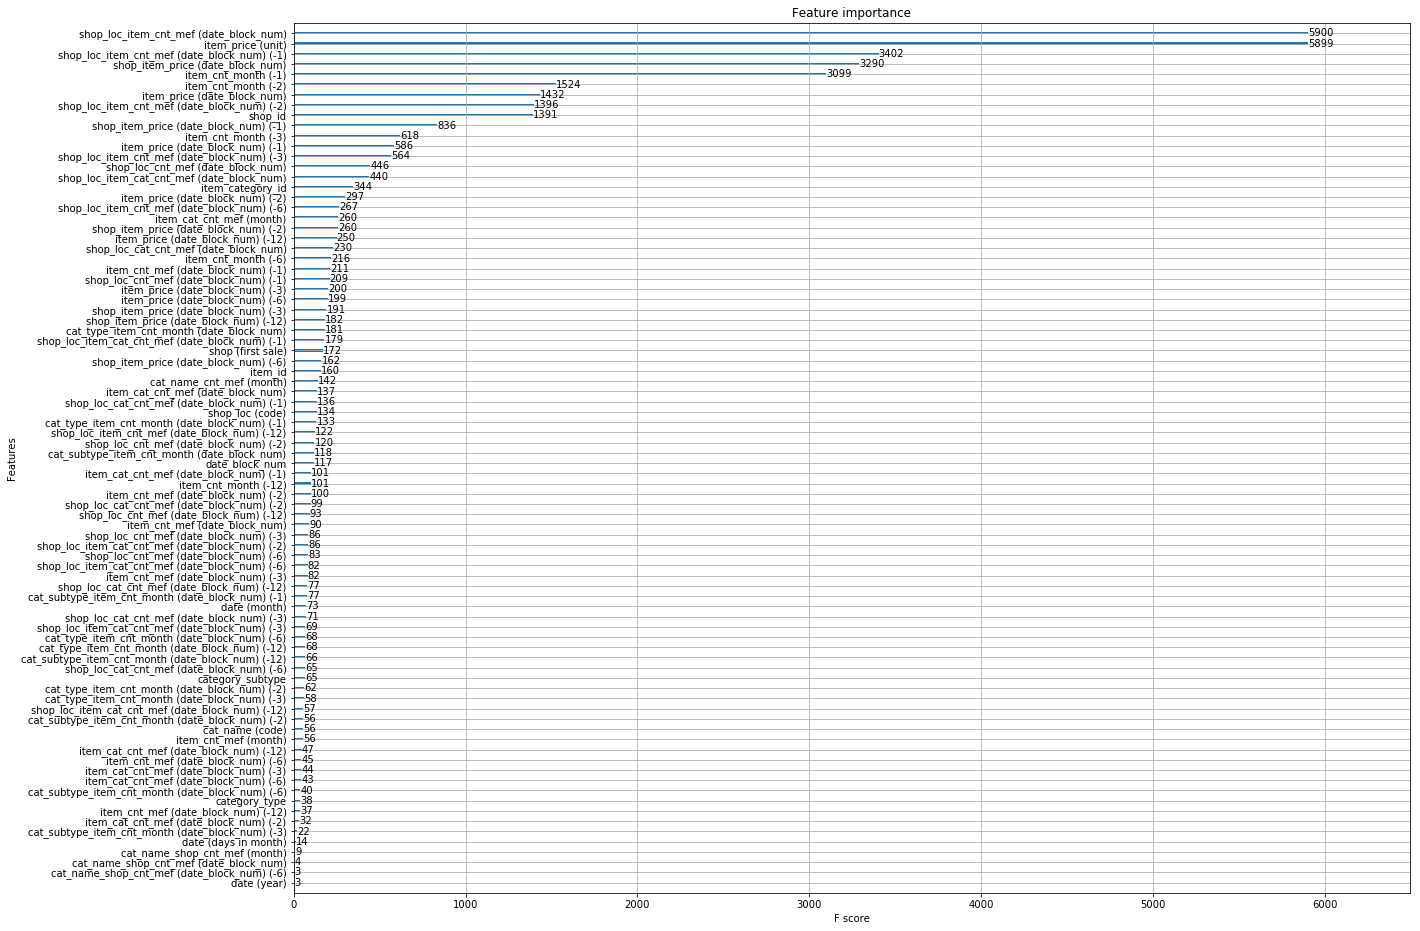

In [26]:
plt.rcParams['figure.figsize'] = (20, 16)

plot_importance(xgb)

In [27]:
pred_df['item_cnt_month'] = xgb.predict(X_pred).clip(0, 20)

pred_df['ID'] = pred_df['ID'].astype(int)

pred_df[['ID', 'item_cnt_month']].to_csv('submissions/final_submission.csv', index=False)

In [28]:
bagged_df = pd.read_csv('submissions/submission-Oct-2015.csv')
bagged_df.head(5)

,ID,item_cnt_month
0,0,0.0
1,1,0.0
2,2,1.0
3,3,0.0
4,4,0.0


In [29]:
bagged_df = bagged_df.merge(pred_df[['ID', 'item_cnt_month']], on='ID')
bagged_df.head(5)

,ID,item_cnt_month_x,item_cnt_month_y
0,0,0.0,0.377505
1,1,0.0,0.000785
2,2,1.0,0.030990
3,3,0.0,0.000000
4,4,0.0,0.001890


In [30]:
bagged_df['item_cnt_month'] = (bagged_df['item_cnt_month_x'] + bagged_df['item_cnt_month_y']) / 2
bagged_df[['ID', 'item_cnt_month']].to_csv('./submissions/bagged-avg.csv', index=False)

In [31]:
def bagged_or(row):
    return 0 if row['item_cnt_month_x'] == 0.0 else row['item_cnt_month_y']
    
bagged_df['item_cnt_month'] = bagged_df.apply(lambda row: bagged_or(row), axis=1
                                             )
bagged_df[['ID', 'item_cnt_month']].to_csv('./submissions/bagged-or.csv', index=False)